In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#from keras.applications.mobilenet import MobileNet
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

*Step 2: Load Data*

In [2]:
imageSize=150
train_dir = "D:\IIIT docs\dip\project\OCT2017\\train/"
test_dir =  "D:\IIIT docs\dip\project\OCT2017\\test/"
# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
#X_train, y_train = get_data(train_dir) # Un-comment to use full dataset: Step 1 of 2
X_test, y_test= get_data(test_dir)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2) # Re-comment to use full dataset: Step 2 of 2

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)

100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:05<00:00, 41.46it/s]


*Step 3: Vizualize Data*

The min/max pixel values are already scaled between 0 and 1

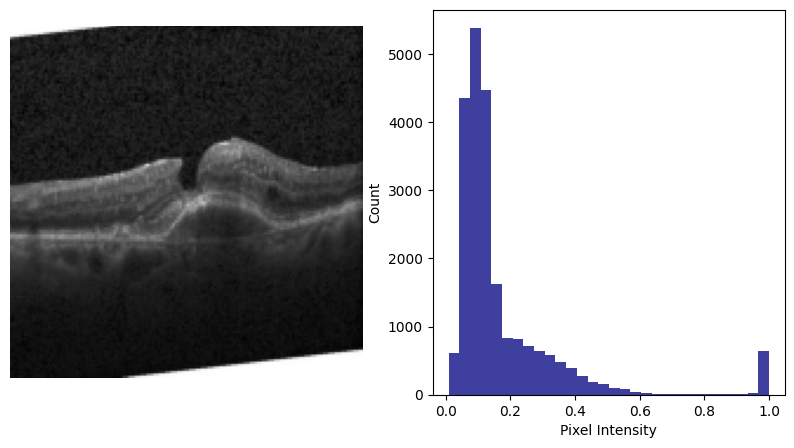

In [3]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

3 OCT images from category "Normal"

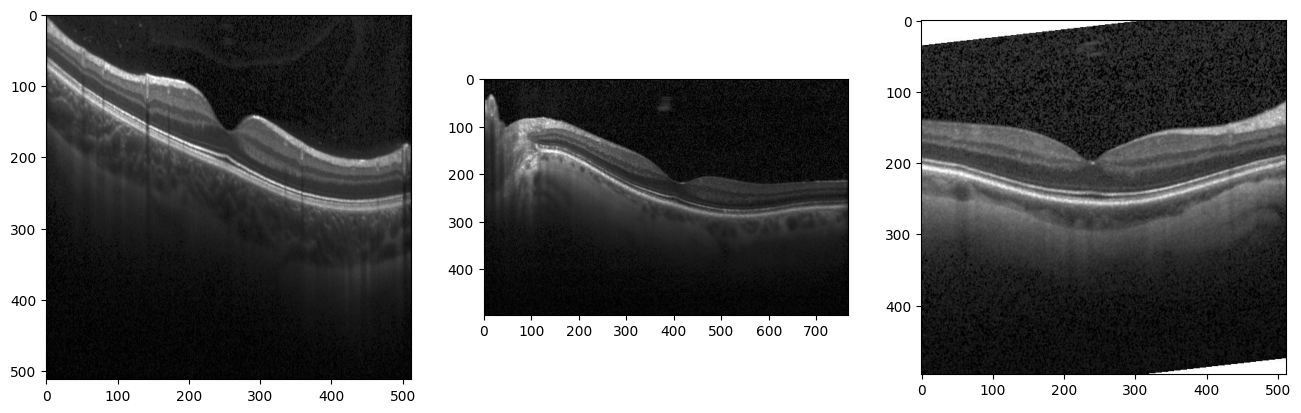

In [4]:
multipleImages = glob('D:\\IIIT docs\dip\project\OCT2017\\train\\NORMAL/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

20 images from category "Normal"

Normal


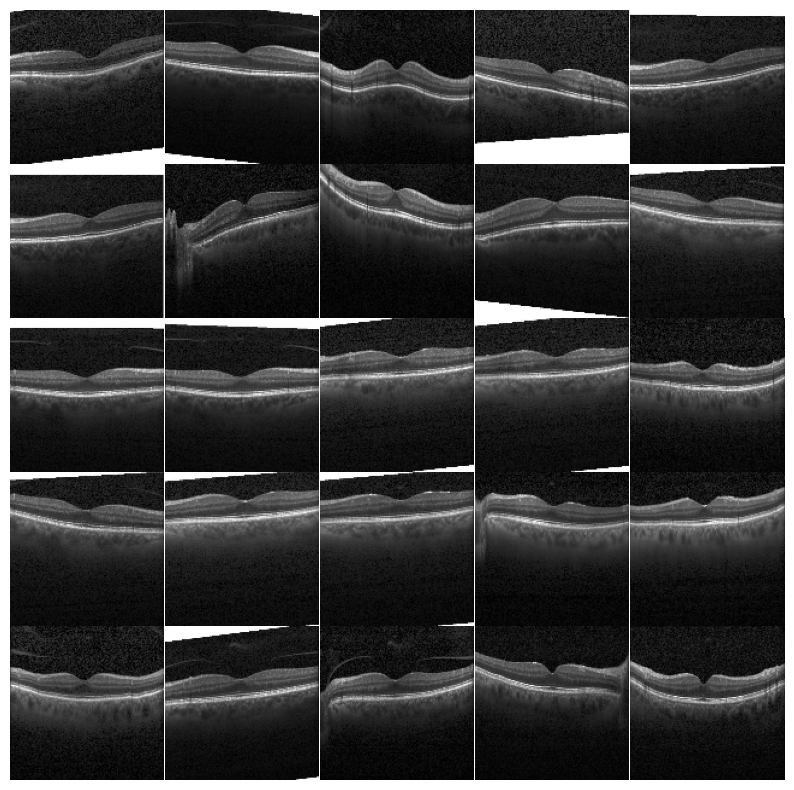

In [5]:
print("Normal")
multipleImages = glob('D:\IIIT docs\dip\project\OCT2017\\train\\NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

20 images from category "CNV"

CNV


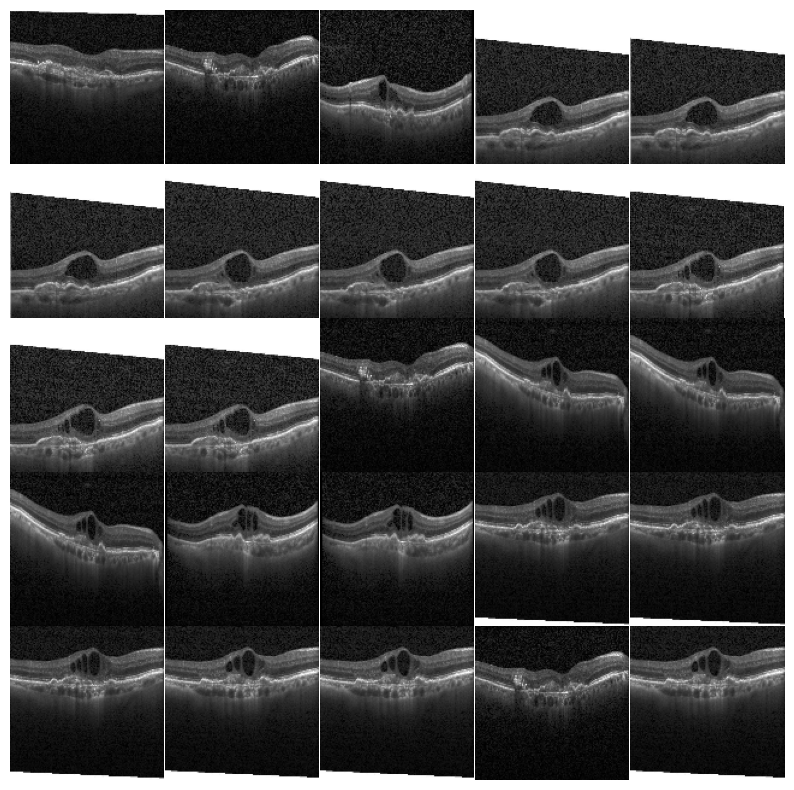

In [6]:
print("CNV")
multipleImages = glob('D:\IIIT docs\dip\project\OCT2017\\train\\CNV/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

20 images from category "DME"

DME


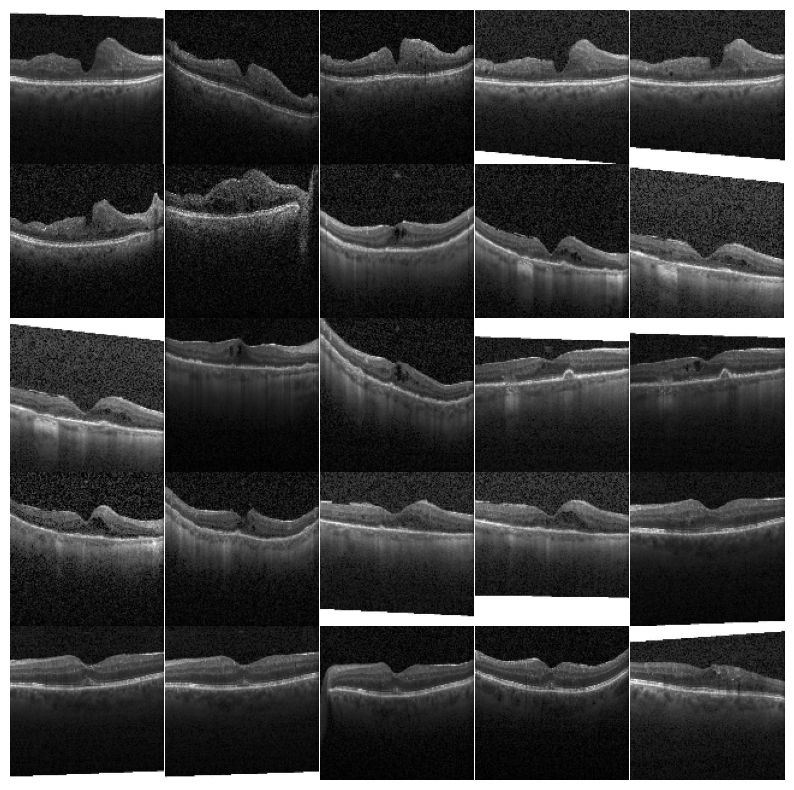

In [7]:
print("DME")
multipleImages = glob('D:\IIIT docs\dip\project\OCT2017\\train\\DME/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

20 images from category "DRUSEN"

DRUSEN


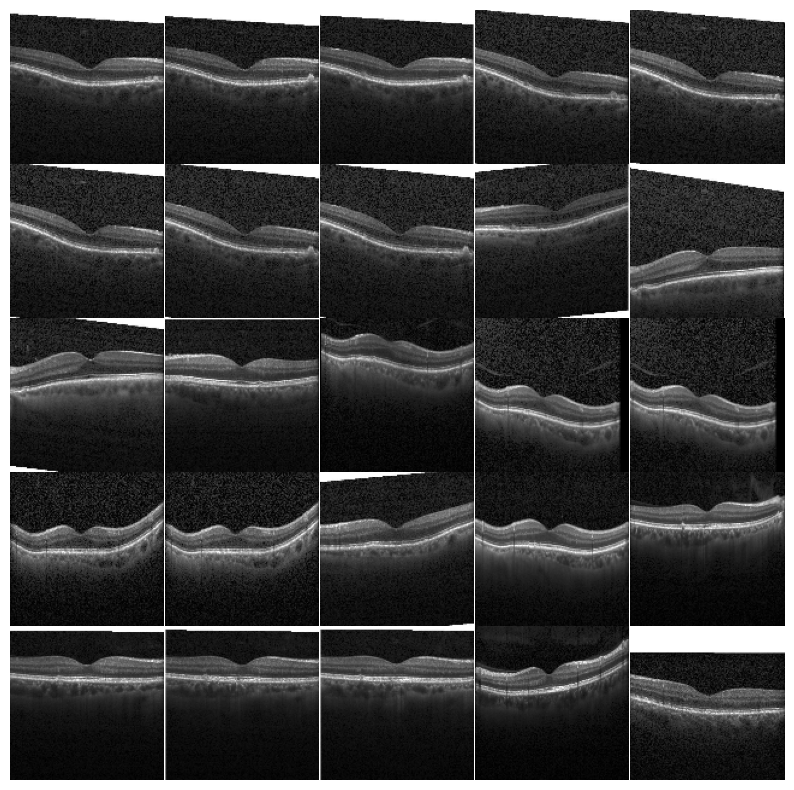

In [8]:
print("DRUSEN")
multipleImages = glob('D:\IIIT docs\dip\project\OCT2017\\train\\DRUSEN/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

{0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}


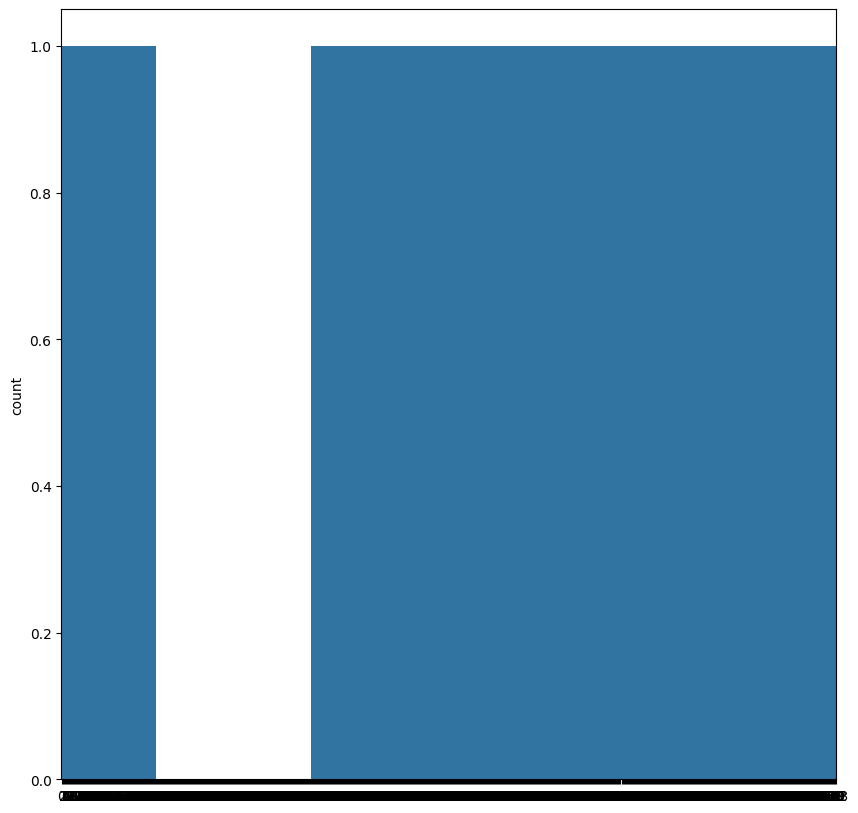

In [9]:
map_characters = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

*Step 4: Define Helper Functions*

In [10]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [11]:
vgg16 = VGG16(include_top= False, input_shape= (imageSize, imageSize, 3), weights= 'imagenet')
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten(input_shape= (4, 4, 512)))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       2

model.compile(optimizer= keras.optimizers.Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
import numpy as np
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
history = model.fit(X_train,y_trainHot, epochs=10, class_weight=class_weights, validation_data=(X_test, y_testHot), verbose=1,callbacks = [MetricsCheckpoint('logs')])


*Step 5: Evaluate Classification Models*

Transfer learning w/ VGG16 Convolutional Network

In [12]:
from sklearn.utils import class_weight
map_characters1 = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}
class_weight1 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
weight_path1 = "D:\IIIT docs\dip\project\OCT2017\\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
weight_path2 = "D:\\IIIT docs\dip\project\OCT2017\\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
pretrained_model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(imageSize, imageSize, 3))
pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = keras.optimizers.Adam()
optimizer2 = keras.optimizers.RMSprop(lr=0.0001)
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    base_model = pretrained_model_1 # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model
#pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_1,weight_path1,class_weight1,4,83,optimizer1,map_characters1)

Transfer learning w/ InceptionV3 Convolutional Network

In [13]:
#pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_2,weight_path2,class_weight1,4,8,optimizer1,map_characters1)

*Step 6: Evaluate Undersampling Strategy*

The goal is to get rid of the class imbalance issues.  Oversampling with data augmentation (e.g. [SMOTE](http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html)) would be preferable to undersampling but undersampling is faster.

This step is only important if you are using the full dataset that has the imbalanced class sizes.  For the purpose of this analysis I am using an abbreviated dataset that does not have imbalanced class sizes (see get_data function) so really the undersampling step is not necessary.

{0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}


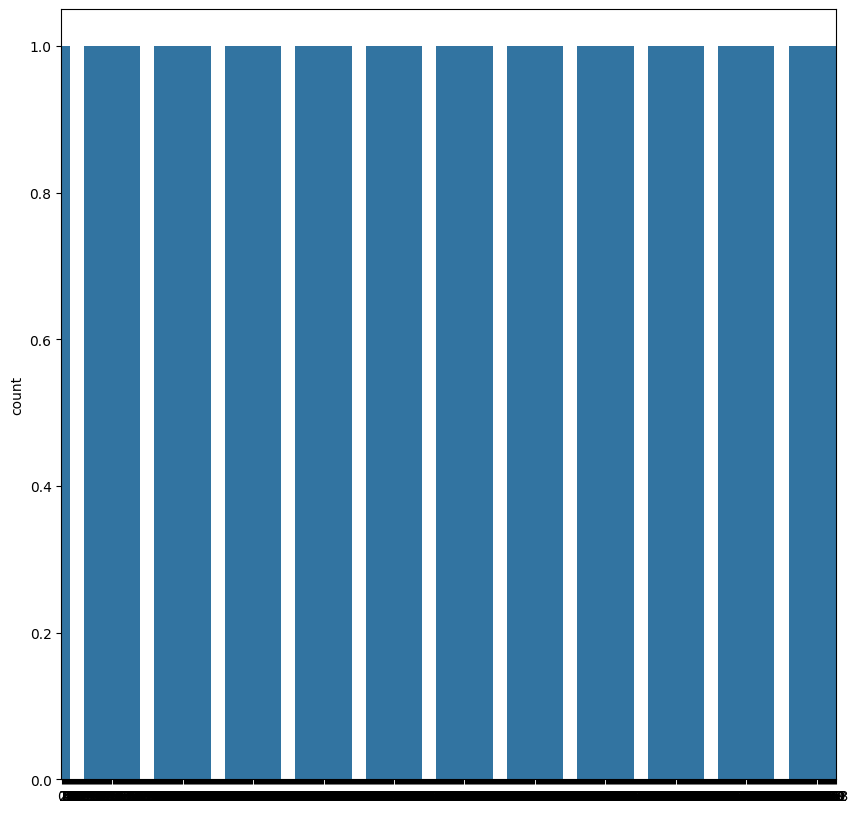

In [14]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(sampling_strategy='auto')

X_trainRos, Y_trainRos = ros.fit_resample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_resample(X_testFlat, Y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 4)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 4)
# Make Data 2D again
for i in range(len(X_trainRos)):
    height, width, channels = imageSize,imageSize,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
for i in range(len(X_testRos)):
    height, width, channels = imageSize,imageSize,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [15]:
class_weight1 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

print("Old Class Weights: ",class_weight1)
class_weight2 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(Y_trainRos), y = Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [0.9872449  0.99742268 1.00259067 1.01308901]
New Class Weights:  [1. 1. 1. 1.]


In [16]:
class_weight_dict1 = {index: weight for index, weight in enumerate(class_weight1)}
class_weight_dict2 = {index: weight for index, weight in enumerate(class_weight2)}

In [17]:
# Shuffle data to permit further subsampling
from sklearn.utils import shuffle
X_trainRosReshaped, Y_trainRosHot = shuffle(X_trainRosReshaped, Y_trainRosHot, random_state=13)
X_testRosReshaped, Y_testRosHot = shuffle(X_testRosReshaped, Y_testRosHot, random_state=13)

*Step 7: Evaluate Final Model*

Transfer learning w/ VGG16 Convolutional Network

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

24/24 [==============================] - 1s 30ms/step - loss: 0.0266 - accuracy: 1.0000 - val_loss: 0.1577 - val_accuracy: 0.9293
Epoch 37/50
24/24 [==============================] - 1s 29ms/step - loss: 0.0255 - accuracy: 1.0000 - val_loss: 0.1545 - val_accuracy: 0.9348
Epoch 38/50
24/24 [==============================] - 1s 30ms/step - loss: 0.0241 - accuracy: 1.0000 - val_loss: 0.1481 - val_accuracy: 0.9565
Epoch 39/50
24/24 [==============================] - 1s 29ms/step - loss: 0.0230 - accuracy: 1.0000 - val_loss: 0.1662 - val_accuracy: 0.9239
Epoch 40/50
24/24 [==============================] - 1s 29ms/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 0.1660 - val_accuracy: 0.9185
Epoch 41/50
24/24 [==============================] - 1s 29ms/step - loss: 0.0211 - accuracy: 1.0000 - val_loss: 0.1414 - val_accuracy: 0.9565
Epoch 42/50
24/24 [==============================] - 1s 29ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.1632 - val_accuracy: 0.9185
Epoch 43/50
24/24 

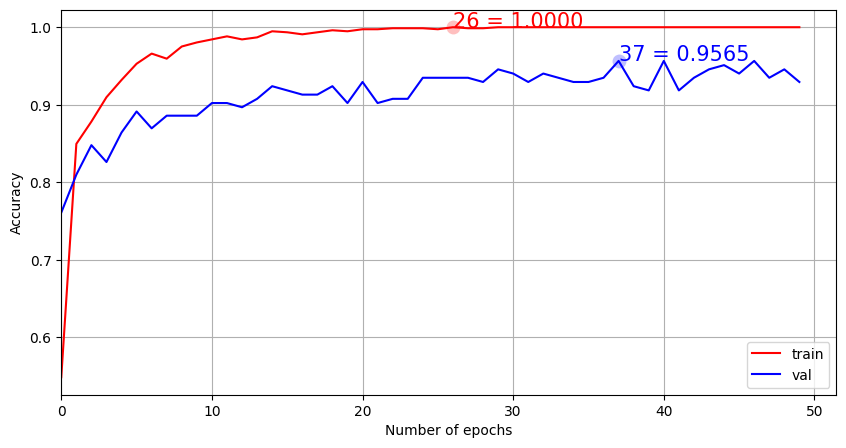

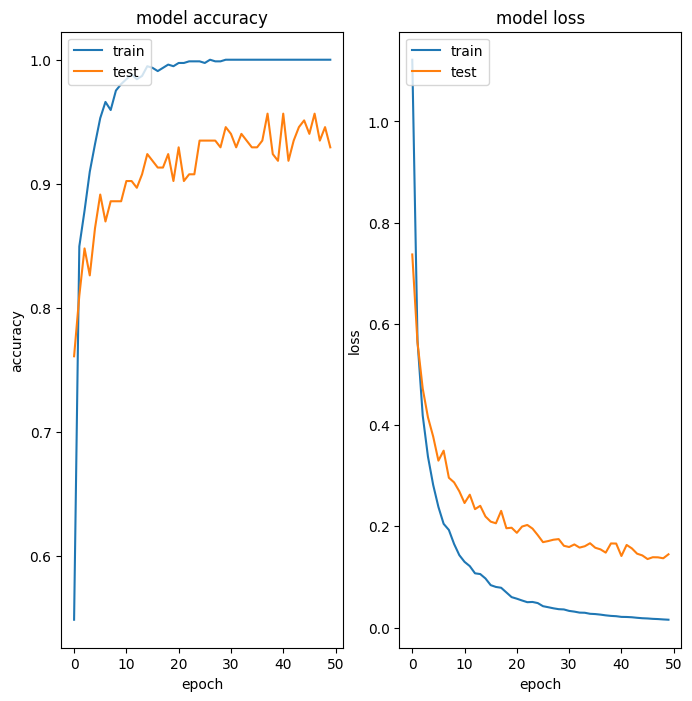

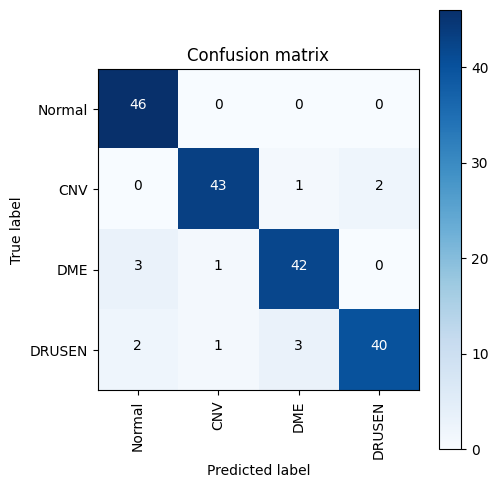

In [18]:
pretrainedNetwork(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:2000], Y_testRosHot[:2000],pretrained_model_1,weight_path1,class_weight_dict2,4,50,optimizer1,map_characters1)

Transfer learning w/ InceptionV3 Convolutional Network

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

24/24 [==============================] - 1s 29ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.1425 - val_accuracy: 0.9239
Epoch 37/50
24/24 [==============================] - 1s 29ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.1520 - val_accuracy: 0.9239
Epoch 38/50
24/24 [==============================] - 1s 29ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.1371 - val_accuracy: 0.9348
Epoch 39/50
24/24 [==============================] - 1s 29ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.1260 - val_accuracy: 0.9457
Epoch 40/50
24/24 [==============================] - 1s 29ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.1403 - val_accuracy: 0.9348
Epoch 41/50
24/24 [==============================] - 1s 31ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.1384 - val_accuracy: 0.9457
Epoch 42/50
24/24 [==============================] - 1s 30ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.1355 - val_accuracy: 0.9348
Epoch 43/50
24/24 

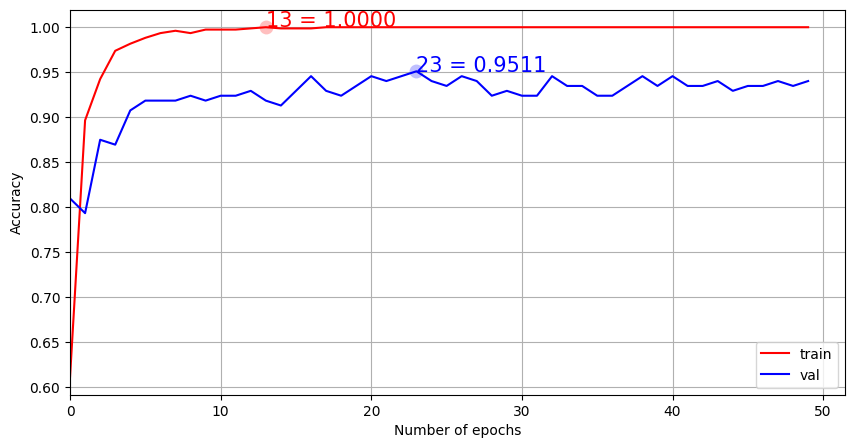

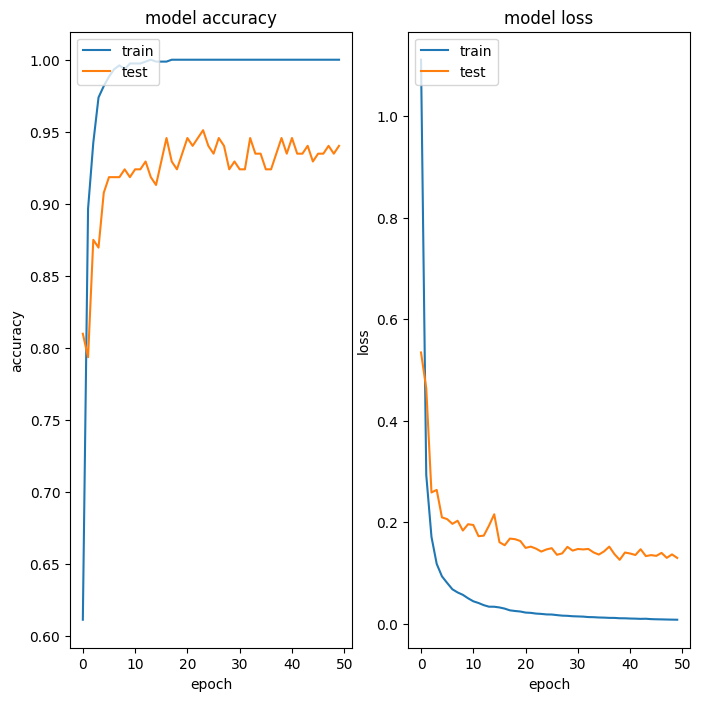

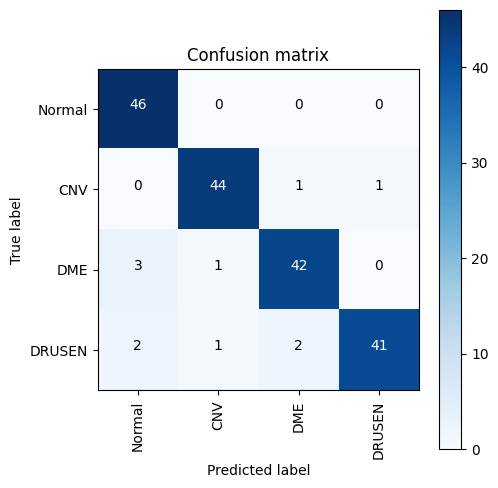

In [19]:
pretrainedNetwork(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:2000], Y_testRosHot[:2000],pretrained_model_2,weight_path2,class_weight_dict2,4,50,optimizer1,map_characters1)

To Do: (1) Try to get accuracy up from 95% to 99%; (2) Add data augmentation; (3) Add ROC curve

 We were able to detect retina damage in OCT images with an accuracy rate of approximately 95%.  That is much better than random chance given 4 different categories and it is of a comparable accuracy to that of medical professionals.